# Air Passengers Forecasting using LSTM and LSTM weights distribution analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import logging

from ts_utils import stationary_check, tsplot

plt.rcParams['figure.figsize'] = 15, 8

from keras import layers
from keras.models import Model, Input
from keras import losses, optimizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/AirPassengers.csv', usecols=[1], header=0)
data = data.values
data = data.astype('float32')

print(data.shape)
print(data[:5])

(144, 1)
[[112.]
 [118.]
 [132.]
 [129.]
 [121.]]


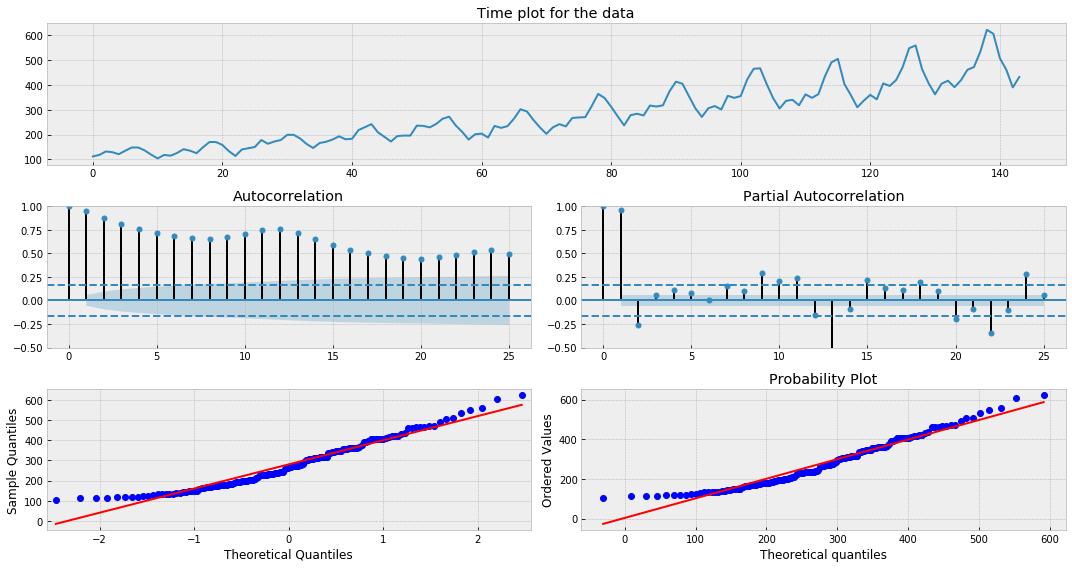

In [3]:
tsplot(data.reshape(-1, ), lags=25, show=True)

In [5]:
scalar = MinMaxScaler(feature_range=(0, 1))
scaled_data = scalar.fit_transform(data)
print(scaled_data[:5])

[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]


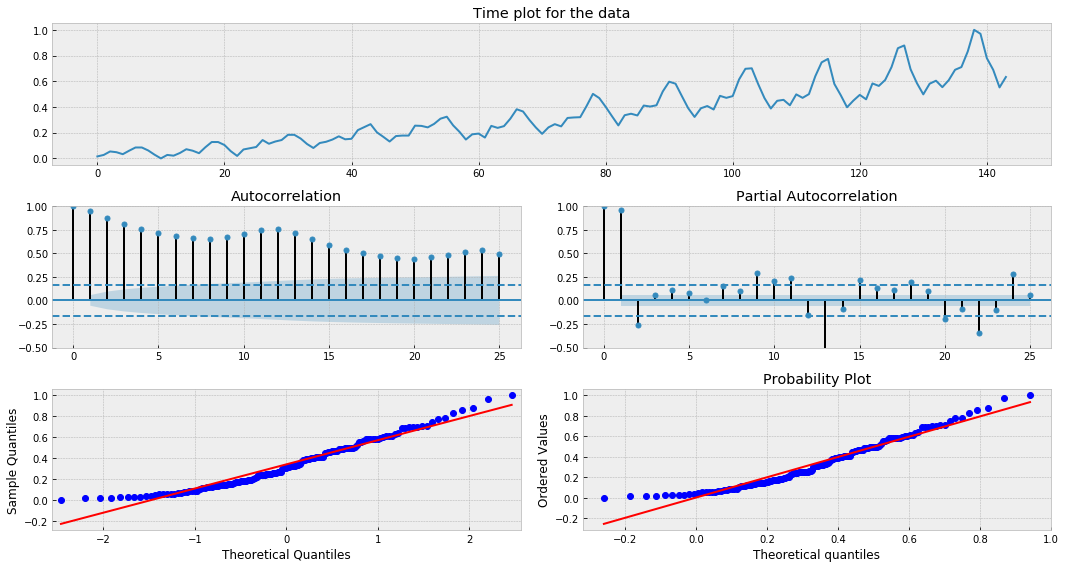

In [6]:
tsplot(scaled_data.reshape(-1, ), lags=25, show=True)

In [7]:
def prepare_data(data, time_step=1):
    dataX = np.zeros((len(data)-time_step-1, 1))
    dataY = np.zeros((len(data)-time_step-1, 1))
    for i in range(len(data)-time_step-1):
        dataX[i, 0] = data[i:(i+time_step), 0]
        dataY[i, 0] = data[i+time_step, 0]
    return dataX, dataY

In [8]:
X, Y = prepare_data(scaled_data, time_step=1)

In [9]:
print(X.shape), print(Y.shape)

(142, 1)
(142, 1)


(None, None)

In [10]:
trainX, testX, trainY, testY = train_test_split(X, Y, train_size=0.80, shuffle=False)

/Users/manish/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
timesteps = 1
features = 1
batch_size = None

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], timesteps, features))
testX = np.reshape(testX, (testX.shape[0], timesteps, features))

In [13]:
input_ = Input(batch_shape=(batch_size, timesteps, features), name='input')
lstm_layer = layers.LSTM(3, activation='tanh', name='lstm')(input_)
dense_layer = layers.Dense(1, name='dense')(lstm_layer)

complete_model = Model(inputs=input_, outputs=dense_layer)
complete_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1, 1)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 3)                 60        
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [14]:
loss = losses.mean_absolute_error
opt = optimizers.Adam()

complete_model.compile(loss=loss, optimizer=opt)

In [18]:
from keras.callbacks import ModelCheckpoint
history = complete_model.fit(trainX, trainY, 
                    epochs=100, 
                    batch_size=1, 
                    verbose=0,
                    callbacks = [ModelCheckpoint(filepath="checkpoints/weights{epoch:03d}.hdf5")]
                   )

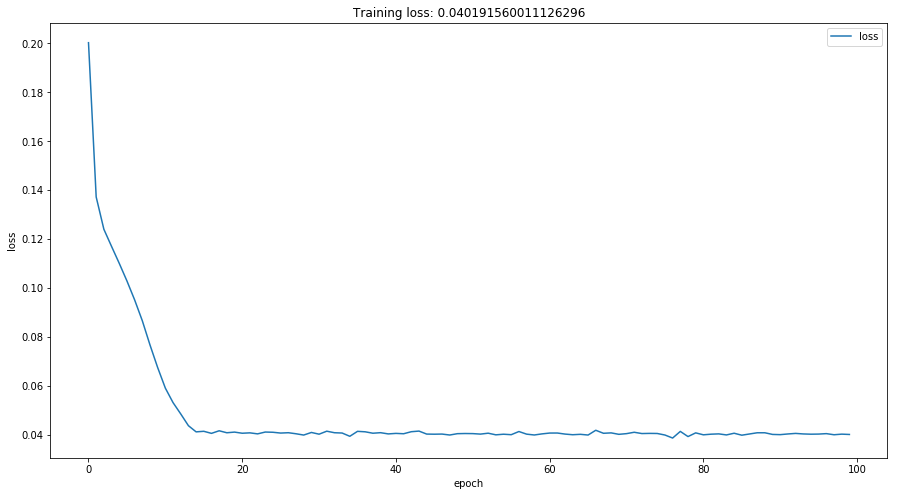

In [19]:
plt.plot(history.history['loss'],label='loss')
# plt.plot(history.history['val_loss'],label='val_loss')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training loss: {}".format(history.history["loss"][-1]))
plt.legend()
plt.show()

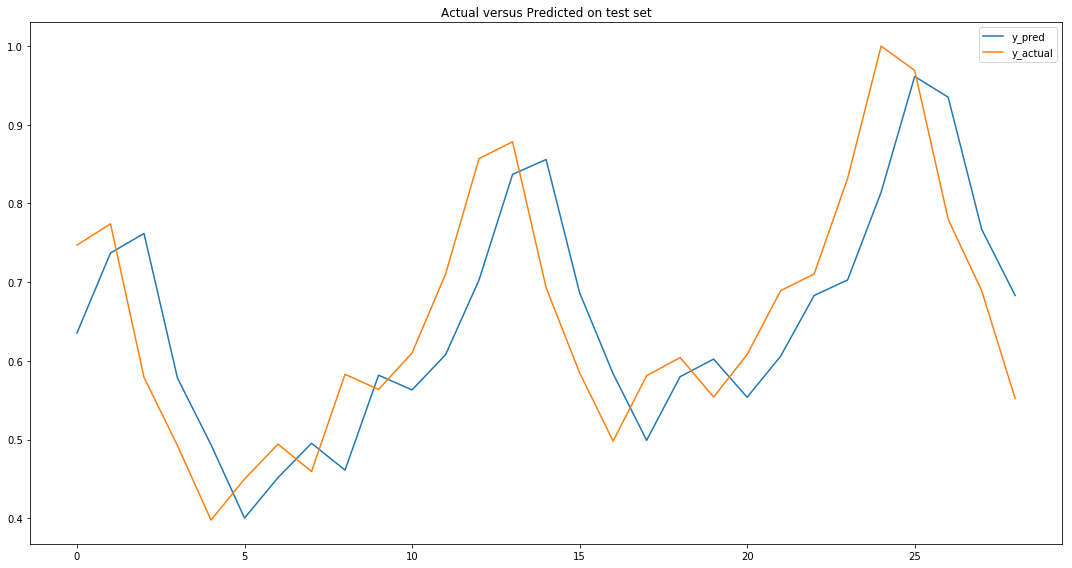

In [21]:
y_pred = complete_model.predict(testX)
plt.plot(y_pred, label = 'y_pred')
plt.plot(testY, label = 'y_actual')
plt.title('Actual versus Predicted on test set')
plt.tight_layout()
plt.legend()
plt.show()

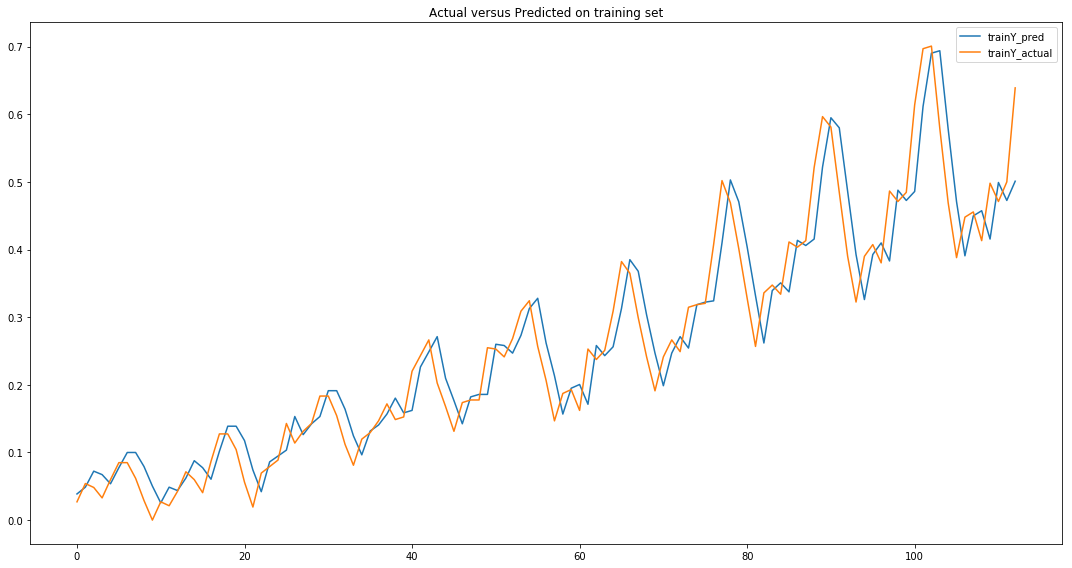

In [22]:
trainY_pred = complete_model.predict(trainX)
plt.plot(trainY_pred, label = 'trainY_pred')
plt.plot(trainY, label = 'trainY_actual')
plt.title('Actual versus Predicted on training set')
plt.tight_layout()
plt.legend()
plt.show()

In [23]:
model_weights = dict()

for layer in complete_model.layers:
    model_weights[layer.name] = layer.get_weights()

print(model_weights)

{'input': [], 'lstm': [array([[ 0.7330628 ,  0.28977576,  1.0180981 , -0.35411754, -0.06132334,
         0.14286667, -0.9262801 ,  1.0696809 ,  0.44804955,  0.40847626,
         0.6181641 ,  0.97243816]], dtype=float32), array([[-0.16193429, -0.4772228 ,  0.18460874, -0.19601265,  0.33254603,
        -0.04262167,  0.03018096, -0.15185915,  0.21776249,  0.45967972,
        -0.46526778, -0.24891508],
       [-0.00722146,  0.09665649,  0.4102927 ,  0.01526247, -0.13887951,
         0.42154497,  0.38094738, -0.6218543 ,  0.1399574 ,  0.01033103,
         0.08804371,  0.25646532],
       [-0.19589429, -0.3981641 , -0.6592164 ,  0.08649384, -0.12815724,
         0.5199759 ,  0.0961623 , -0.0306629 , -0.17430627,  0.12186029,
         0.02194412,  0.13543466]], dtype=float32), array([ 0.5633393 ,  0.67255634,  0.10451638,  1.        ,  1.        ,
        1.        , -0.00213224, -0.03258241,  0.0940429 ,  0.554809  ,
        0.6494031 ,  0.10305841], dtype=float32)], 'dense': [array([[-1.200

In [24]:
lstm_model = Model(inputs=input_, outputs=lstm_layer)
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1, 1)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 3)                 60        
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________


In [25]:
lstm_model.compile(loss=loss, optimizer=opt)

In [26]:
lstm_pred = lstm_model.predict(trainX)
print(lstm_pred.shape)

(113, 3)


In [27]:
dense_weight = model_weights['dense']
dense_weight

[array([[-1.2006878 ],
        [ 0.57655424],
        [ 1.3481197 ]], dtype=float32), array([-0.00223349], dtype=float32)]

In [28]:
d_w = np.zeros(3)
for i in range(3):
    d_w[i] = dense_weight[0][i][0]
    
print(d_w.shape)

(3,)


In [29]:
print(lstm_pred[:5, :])

[[-0.00618764 -0.0064473   0.02758477]
 [-0.01026827 -0.00147904  0.02924505]
 [-0.01991063  0.01024114  0.03321189]
 [-0.01783071  0.00771555  0.0323509 ]
 [-0.01232052  0.00101787  0.03008413]]


In [30]:
print(lstm_pred[:5, :]*d_w)

[[ 0.00742942 -0.00371722  0.03718757]
 [ 0.01232899 -0.00085275  0.03942582]
 [ 0.02390645  0.00590457  0.04477361]
 [ 0.02140911  0.00444843  0.04361289]
 [ 0.0147931   0.00058686  0.04055701]]


In [31]:
lstm_contribution = lstm_pred * d_w

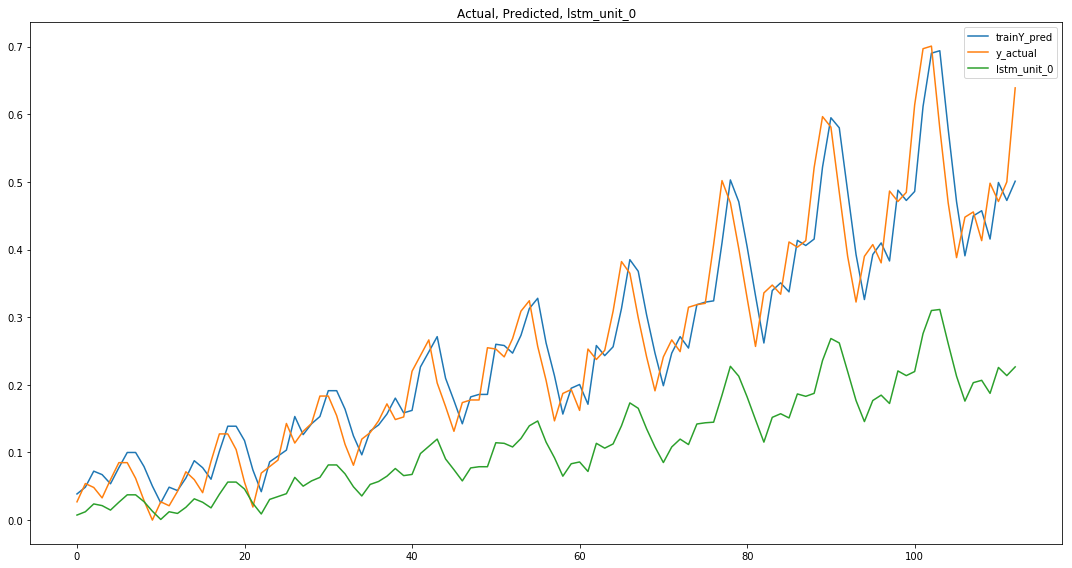

In [32]:
plt.plot(trainY_pred, label = 'trainY_pred')
plt.plot(trainY, label = 'y_actual')
plt.plot(lstm_contribution[:, 0], label='lstm_unit_0')
plt.title('Actual, Predicted, lstm_unit_0')
plt.tight_layout()
plt.legend()
plt.show()

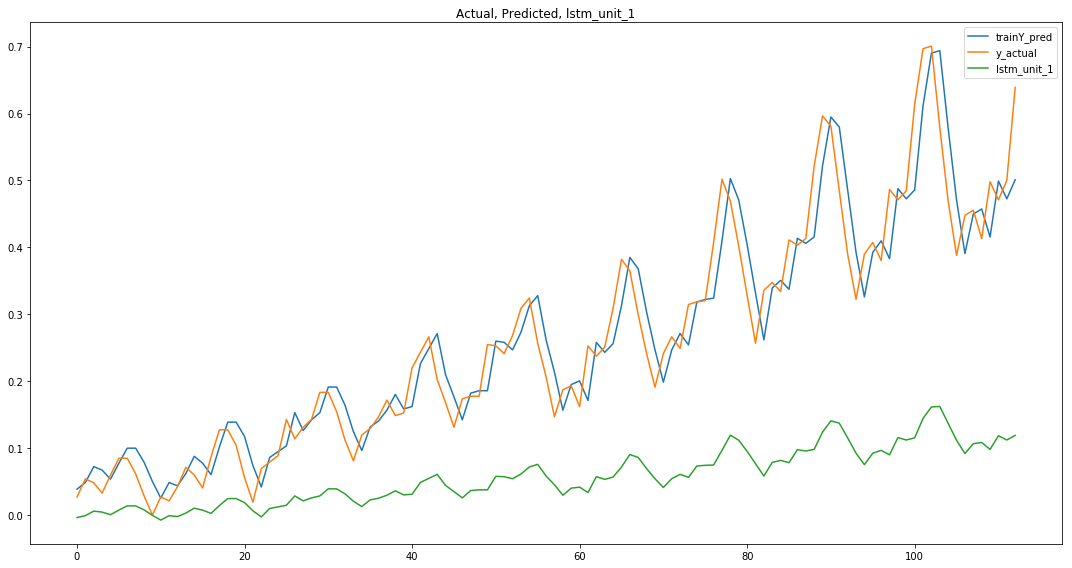

In [33]:
plt.plot(trainY_pred, label = 'trainY_pred')
plt.plot(trainY, label = 'y_actual')
plt.plot(lstm_contribution[:, 1], label='lstm_unit_1')
plt.title('Actual, Predicted, lstm_unit_1')
plt.tight_layout()
plt.legend()
plt.show()

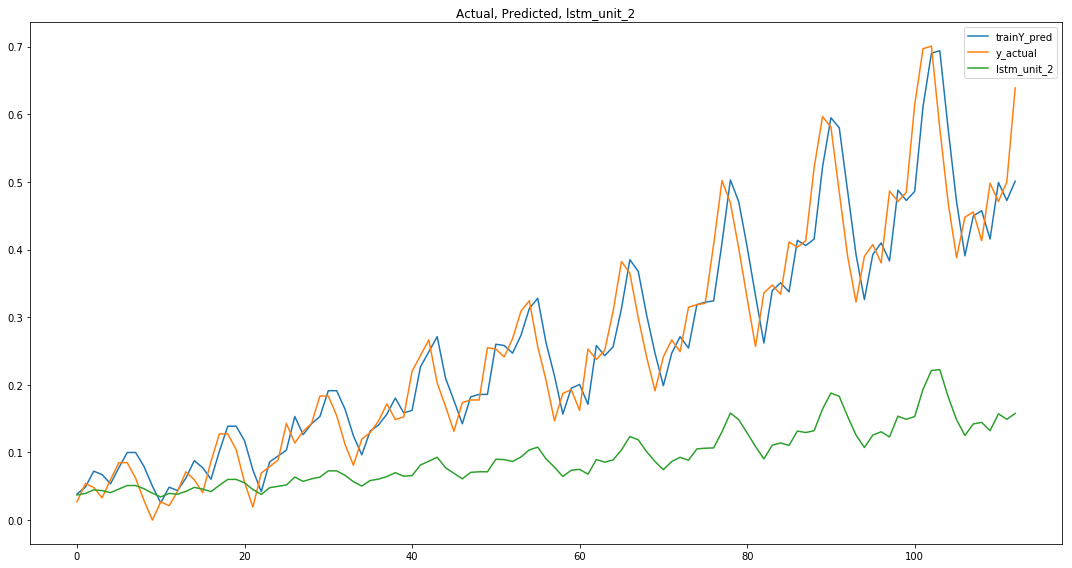

In [34]:
plt.plot(trainY_pred, label = 'trainY_pred')
plt.plot(trainY, label = 'y_actual')
plt.plot(lstm_contribution[:, 2], label='lstm_unit_2')
plt.title('Actual, Predicted, lstm_unit_2')
plt.tight_layout()
plt.legend()
plt.show()

In [35]:
W, U, B = model_weights['lstm']
# input weights (3, input, 3 forget, 3 cell weight, 3 output) 
print(W)
print(U)
print(B)

[[ 0.7330628   0.28977576  1.0180981  -0.35411754 -0.06132334  0.14286667
  -0.9262801   1.0696809   0.44804955  0.40847626  0.6181641   0.97243816]]
[[-0.16193429 -0.4772228   0.18460874 -0.19601265  0.33254603 -0.04262167
   0.03018096 -0.15185915  0.21776249  0.45967972 -0.46526778 -0.24891508]
 [-0.00722146  0.09665649  0.4102927   0.01526247 -0.13887951  0.42154497
   0.38094738 -0.6218543   0.1399574   0.01033103  0.08804371  0.25646532]
 [-0.19589429 -0.3981641  -0.6592164   0.08649384 -0.12815724  0.5199759
   0.0961623  -0.0306629  -0.17430627  0.12186029  0.02194412  0.13543466]]
[ 0.5633393   0.67255634  0.10451638  1.          1.          1.
 -0.00213224 -0.03258241  0.0940429   0.554809    0.6494031   0.10305841]


In [36]:
def extract_lstm_uwb(weight):

    input_weight, hidden_weight, bias = weight
    gates = ["input","forget","cell","output"]
    
    hidden_units = hidden_weight.shape[0]
    
    U, W, b = {}, {}, {}
    
    for i,j in enumerate(range(0, len(bias), hidden_units)):
        
        W[gates[i]] = input_weight[:, j:j+hidden_units]
        U[gates[i]] = hidden_weight[:, j:j+hidden_units]
        b[gates[i]] = bias[j:j+hidden_units].reshape(hidden_units, 1)
    
    return W, U, b

In [37]:
W, U, b = extract_lstm_uwb(model_weights['lstm'])

In [38]:
print(W)

{'input': array([[0.7330628 , 0.28977576, 1.0180981 ]], dtype=float32), 'forget': array([[-0.35411754, -0.06132334,  0.14286667]], dtype=float32), 'cell': array([[-0.9262801 ,  1.0696809 ,  0.44804955]], dtype=float32), 'output': array([[0.40847626, 0.6181641 , 0.97243816]], dtype=float32)}


In [39]:
U

{'cell': array([[ 0.03018096, -0.15185915,  0.21776249],
        [ 0.38094738, -0.6218543 ,  0.1399574 ],
        [ 0.0961623 , -0.0306629 , -0.17430627]], dtype=float32),
 'forget': array([[-0.19601265,  0.33254603, -0.04262167],
        [ 0.01526247, -0.13887951,  0.42154497],
        [ 0.08649384, -0.12815724,  0.5199759 ]], dtype=float32),
 'input': array([[-0.16193429, -0.4772228 ,  0.18460874],
        [-0.00722146,  0.09665649,  0.4102927 ],
        [-0.19589429, -0.3981641 , -0.6592164 ]], dtype=float32),
 'output': array([[ 0.45967972, -0.46526778, -0.24891508],
        [ 0.01033103,  0.08804371,  0.25646532],
        [ 0.12186029,  0.02194412,  0.13543466]], dtype=float32)}

In [40]:
b

{'cell': array([[-0.00213224],
        [-0.03258241],
        [ 0.0940429 ]], dtype=float32), 'forget': array([[1.],
        [1.],
        [1.]], dtype=float32), 'input': array([[0.5633393 ],
        [0.67255634],
        [0.10451638]], dtype=float32), 'output': array([[0.554809  ],
        [0.6494031 ],
        [0.10305841]], dtype=float32)}

In [41]:
def lstm_parameter_label(W,U,b):
    
    bias, b_label = [], []
    weight, w_label = [], []
    cell, c_label= [], []
    
    for i in ["input", "forget", "cell", "output"]:
        
        temp = list(W[i].flatten())
        w_label.extend(["W_"+ i] * len(temp))
        weight.extend(temp)

        temp = list(U[i].flatten())
        c_label.extend(["U_"+ i] * len(temp))
        cell.extend(temp)    

        temp = list(b[i].flatten())
        b_label.extend(["b_"+ i] * len(temp))
        bias.extend(temp)  
    
    combined_parameter = weight + cell + bias
    combined_label = w_label + c_label + b_label
    
    return combined_parameter, combined_label

In [42]:
lstm_parameters, lstm_labels = lstm_parameter_label(W, U, b)

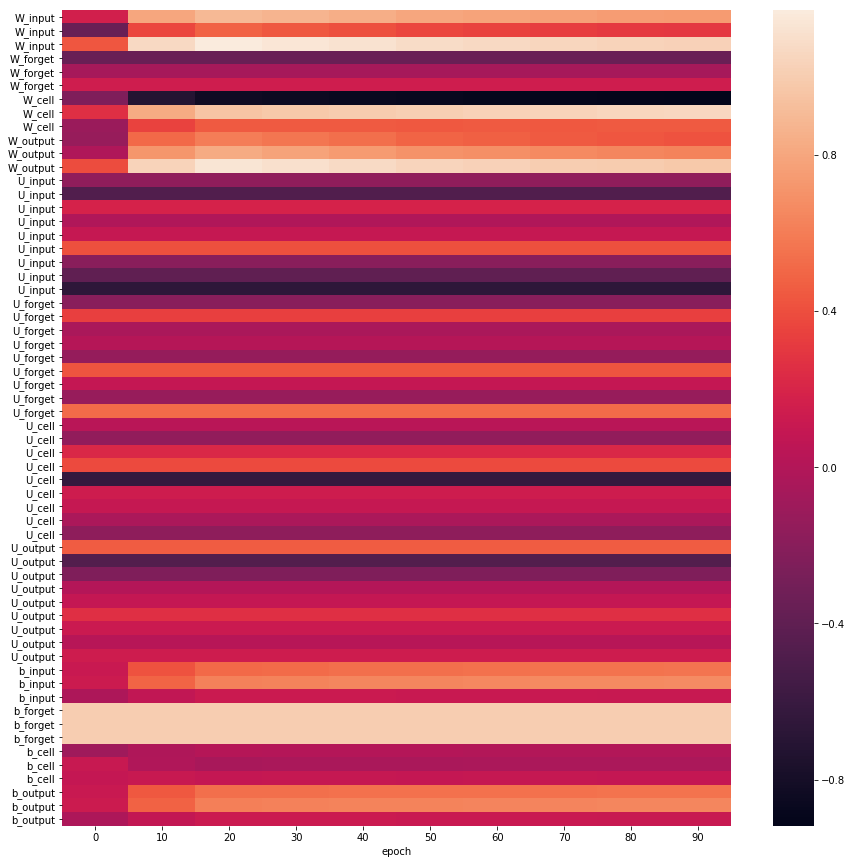

In [57]:
from copy import copy
import os
LOGDIR = 'checkpoints/'

df = {}

for epoch in np.arange(0, 100, 10):
    complete_model.load_weights(os.path.join(LOGDIR + "weights{:03d}.hdf5".format(epoch+1)))
    
    for layer in complete_model.layers:
        if 'lstm' in str(layer.name):
            weight = layer.get_weights()
            break
    WUb = (extract_lstm_uwb(weight))
    parameter, label = lstm_parameter_label(*WUb)
    df[epoch] = copy(parameter)

df = pd.DataFrame(df, index=label)
df = df[np.sort(df.columns)]

plt.figure(figsize=(15,15))
sns.heatmap(df)
plt.xlabel('epoch')
plt.show()